In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
class NeuralNetwork:
    def __init__(self, layers):
      self.layers = layers
      self.length = len(layers)
      self.num_features = layers[0]
      self.num_classes = layers[-1] 
      self.weight = {}
      self.bias = {}
      self.derivative_weight = {}
      self.derivative_bias = {} 
      self.setup()
        
    def setup(self):
      for i in range(1, self.length):
          self.weight[i] = tf.Variable(tf.random.normal(shape = (self.layers[i], self.layers[i-1])))
          self.bias[i] = tf.Variable(tf.random.normal(shape = (self.layers[i], 1)))

    def forward_pass(self, input_data): 
      output_layer = tf.convert_to_tensor(input_data, dtype = tf.float32)
      for i in range(1, self.length):
          input_data_represented = tf.matmul(output_layer, tf.transpose(self.weight[i])) + tf.transpose(self.bias[i])
          if i != self.length-1:
              output_layer = tf.nn.relu(input_data_represented)
          else:
              output_layer = input_data_represented
      return output_layer

    def compute_loss(self, labels_pred, labels):
      loss = tf.nn.softmax_cross_entropy_with_logits(labels, labels_pred)
      return tf.reduce_mean(loss)
    
    def update_params(self, lr):
      for i in range (1, self.length):
          self.weight[i].assign_sub(lr * self.derivative_weight[i])
          self.bias[i].assign_sub(lr * self.derivative_bias[i])
    
    def predict(self, input_data):
      output = self.forward_pass(input_data)
      labels = tf.argmax(tf.nn.softmax(output), axis = 1)
      return labels
          
    def info(self):
      num_params = 0
      for i in range(1, self.length):
          num_params += self.weight[i].shape[0] * self.weight[i].shape[1]
          num_params += self.bias[i].shape[0]
      print('Input Features:', self.num_features)
      print('Number of Classes:', self.num_classes)
      print('Hidden Layers:')
      print('--------------')
      for i in range(1, self.length-1):
          print('Layer {}, Units {}'.format(i, self.layers[i]))
      print('--------------')
      print('Number of parameters:', num_params)

    def train_on_batch(self, X_batch, y_batch, learning_rate):
      X_batch = tf.convert_to_tensor(X_batch, dtype = tf.float32)
      y_batch = tf.convert_to_tensor(y_batch, dtype = tf.float32)
      
      # Record operations for automatic differentiation
      with tf.GradientTape(persistent = True) as tape:
          y_batch_pred = self.forward_pass(X_batch)
          loss = self.compute_loss(y_batch_pred, y_batch)
      for i in range(1, self.length):
          self.derivative_weight[i] = tape.gradient(loss, self.weight[i])
          self.derivative_bias[i] = tape.gradient(loss, self.bias[i])
      del tape
      self.update_params(learning_rate)
      return loss.numpy()

    def fit(self, X_train, y_train, X_val, y_val, epochs, steps_per_epoch, batch_size, learning_rate):
      history = {
          'val_loss': [],
          'train_loss': [],
          'val_acc': []
      }
      for e in range(0, epochs):
          epoch_train_loss = 0
          print('Epoch {} '.format(e + 1), end = '.')
          for i in range(0, steps_per_epoch):
              X_batch = X_train[i * batch_size: (i+1) * batch_size]
              y_batch = y_train[i * batch_size: (i+1) * batch_size]
              batch_loss = self.train_on_batch(X_batch, y_batch, learning_rate)
              epoch_train_loss += batch_loss
              
              if i % int(steps_per_epoch/10) == 0:
                  print(end = '.')       
          history['train_loss'].append(epoch_train_loss / steps_per_epoch)
          out_layer_val = self.forward_pass(X_val)
          val_loss = self.compute_loss(out_layer_val, y_val).numpy()
          history['val_loss'].append(val_loss)
          
          y_val_pred = self.predict(X_val)
          val_acc = np.mean(np.argmax(y_val, axis = 1) == y_val_pred.numpy())
          history['val_acc'].append(val_acc)
          print(' val_acc:', val_acc)
      return history

    def evaluate(self, X_test, y_test):
      y_pred = self.predict(X_test)
      test_acc = np.mean(np.argmax(y_test, axis = 1) == y_pred.numpy())
      return test_acc


Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


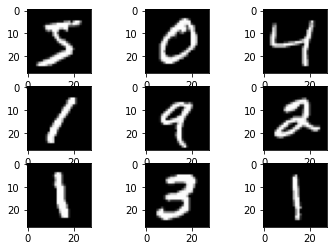

In [ ]:
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))
# plot first few images
for i in range(9):
	plt.subplot(330 + 1 + i)
	plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
# Preprocess the data 
X_train = X_train.reshape(60000, 784).astype("float32") / 255
X_test = X_test.reshape(10000, 784).astype("float32") / 255

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
# Reserve 10,000 samples for validation
X_val = X_train[-10000:]
y_val = y_train[-10000:]
X_train = X_train[:-10000]
y_train = y_train[:-10000]

In [ ]:
model = NeuralNetwork([784, 128, 128, 10])
model.info()

Input Features: 784
Number of Classes: 10
Hidden Layers:
--------------
Layer 1, Units 128
Layer 2, Units 128
--------------
Number of parameters: 118282


In [ ]:
batch_size = 128 
epochs = 5
steps_per_epoch = int(X_train.shape[0] / batch_size)
learning_rate = 0.01
print('Steps per epoch', steps_per_epoch)

Steps per epoch 390


In [ ]:
history = model.fit(X_train, y_train, 
                    X_val, y_val,
                    epochs, steps_per_epoch, 
                    batch_size, learning_rate)

Epoch 1 ........... val_acc: 0.8445
Epoch 2 ........... val_acc: 0.8654
Epoch 3 ........... val_acc: 0.8742
Epoch 4 ........... val_acc: 0.8763
Epoch 5 ........... val_acc: 0.8802


In [ ]:
history

{'train_loss': [37.92792473817483,
  11.21126803618211,
  7.198046119702168,
  5.298514870191232,
  4.165000630800541],
 'val_acc': [0.8445, 0.8654, 0.8742, 0.8763, 0.8802],
 'val_loss': [13.639097, 8.543267, 6.449476, 5.3227525, 4.4887123]}

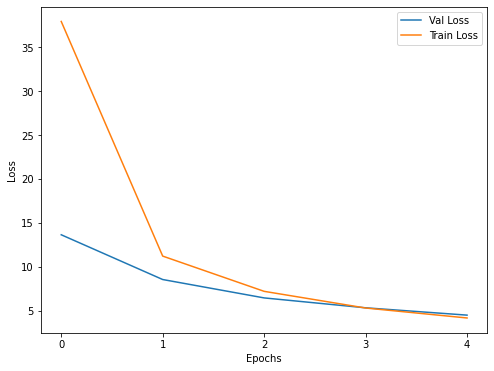

In [ ]:
plt.figure(figsize=(8, 6))
epochs = len(history['val_loss'])
plt.plot(range(epochs), history['val_loss'], label='Val Loss')
plt.plot(range(epochs), history['train_loss'], label='Train Loss')
plt.xticks(list(range(epochs)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy is {}.".format(test_acc))

Test Accuracy is 0.8762.
